# Introduction
This notebook analyses an image and attempts to reduce as many colours as possible.

## Setup
We first import the required modules.


In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import random
from collections import defaultdict, deque

## Heler classes
We define two helper classes - ColourPixel and ColourCluster to store the data needed when executing this model.

The operators are also modified here so future code can be written more concisely.

In [3]:
class ColourPixel(object):
    """
    Represents a pixel by its RGB values.
    """

    def __init__(self, pixel, row=None, col=None):
        """
        Class constructor.
        """
        self.red = int(pixel[0])
        self.green = int(pixel[1])
        self.blue = int(pixel[2])
        self.r = row
        self.c = col

    @staticmethod
    def distance(point_a, point_b):
        """
        Calculates distance between two points.
        """
        if isinstance(point_a, ColourPixel) and isinstance(point_b, ColourPixel):
            return np.sqrt(
                (point_a.red - point_b.red) ** 2
                + (point_a.blue - point_b.blue) ** 2
                + (point_a.green - point_b.green) ** 2
            )

    def __sub__(self, x):
        """
        Subtract operator.
        """
        if isinstance(x, ColourPixel):
            return ColourPixel(
                [self.red - x.red, self.green - x.green, self.blue - x.blue]
            )
        else:
            return ColourPixel([self.red - x, self.green - x, self.blue - x])

    def __truediv__(self, x):
        """
        Divide operator.
        """
        return ColourPixel([self.red / x, self.green / x, self.blue / x])

    def __add__(self, x):
        """
        Add operator.
        """
        if isinstance(x, ColourPixel):
            return ColourPixel(
                [self.red + x.red, self.green + x.green, self.blue + x.blue]
            )
        else:
            return ColourPixel([self.red + x, self.green + x, self.blue + x])

    def __eq__(self, x):
        """
        Compares if two pixels have the same values.
        """
        if isinstance(x, ColourPixel):
            return self.red == x.red and self.green == x.green and self.blue == x.blue
        else:
            return NotImplemented

    def __repr__(self):
        """
        Returns a string that prints own RGB values.
        """
        return str((self.red, self.green, self.blue))


class ColourCluster(object):
    """
    Stores a list of colour pixels.
    """

    def __init__(self, points=[], default=None):
        """
        Class constructor.
        """
        self.pixels = deque(points)
        self.default = default

    def append(self, x):
        """
        Adds new pixels to cluster.
        """
        if isinstance(x, ColourPixel):
            self.pixels.append(x)

    def __repr__(self):
        """
        Returns a string with own mean value.
        """
        return f"<ColourCluster @{ self.mean_value }>"

    def clear_cluster_keep_position(self):
        """
        Updates self default and removes all pixels assigned to this.
        """
        if len(self.pixels) > 0:
            self.update_average()
            self.pixels.clear()

    def update_average(self):
        if len(self.pixels) > 0:
            total_pixels = len(self.pixels)
            red_average, green_average, blue_average = (
                int(sum([x.red for x in self.pixels]) / total_pixels),
                int(sum([x.green for x in self.pixels]) / total_pixels),
                int(sum([x.blue for x in self.pixels]) / total_pixels),
            )

            self.default = ColourPixel([red_average, green_average, blue_average])

    @property
    def mean_value(self):
        """
        Returns the mean of all pixels in this cluster.
        """
        return self.default


## Setup part 2
We then declare a few more functions that will be needed to orchestrate the creation and general use with these two object classe.

In [4]:

def create_clusters(count):
    """
    Create count ^ 3 clusters equally apart in the colour space.
    """
    clusters = deque()
    for r in range(count):
        for g in range(count):
            for b in range(count):
                red = 0 if r == 0 else 255 / r
                green = 0 if g == 0 else 255 / g
                blue = 0 if b == 0 else 255 / b
                clusters.append(ColourCluster([], ColourPixel([red, green, blue])))

    return clusters


def create_random_clusters(count):
    """
    Create x clusters randomly in the colour space.
    """
    clusters = deque()
    for i in range(count):
        red, green, blue = (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255),
        )
        clusters.append(ColourCluster([], ColourPixel([red, green, blue])))

    return clusters


def get_closest_cluster(point, clusters):
    """
    Return the closest cluster from the given point in the given list of clusters.
    """
    distance = defaultdict(ColourCluster)
    if isinstance(point, ColourCluster):
        point = point.defaults

    for cluster in clusters:
        distance[ColourPixel.distance(cluster.mean_value, point)] = cluster

    return distance[min(distance.keys())], min(distance.keys())


## Main event

Finally, we have arrived at the core alrogithm. We are going to reduce the colour count of the following image.

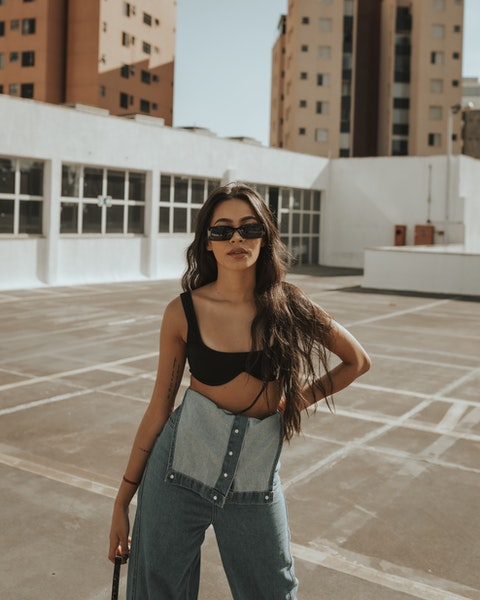


In [5]:
# Declare input and output file paths.
input_file = "/home/input.jpg"
output_file = "/home/output.jpg"

# For this example we will use uniform clusters - or by turning this off random clusters will be created instead.
cluster_factor = 3
cluster_count = 20
uniform_clusters = True

# We read the image in a numpy array and print the relevant initial information.
im = np.array(Image.open(input_file))

print(f"Image represented with datatype {im.dtype}")
print(f"Image represented in {im.ndim} dimensions")
print(f"Total number of pixels {im.shape[0] * im.shape[1]}")
print(
    f"Creating {f'{cluster_factor ** 3 } uniform' if uniform_clusters else f'{cluster_count} random'} clusters"
)

Image represented with datatype uint8
Image represented in 3 dimensions
Total number of pixels 288000
Creating 27 uniform clusters


In [6]:
# We create our clusters from based on the above specification.
if uniform_clusters:
    stock_clusters = create_clusters(cluster_factor)
else:
    stock_clusters = create_random_clusters(cluster_count)

## Main loop algorithm

We iterate through all the pixels and create a ColourPixel object with the RGB values.

Then we perform a initial run, in which we assign each pixel to its closest cluster.

The distribution of number of pixels in each cluster is then displayed, along with the number of non-empty clusters, which indicates how many colours has the current iteration reduce the image into.

A prompt then asks if the user would like to continue with more runs, if they do, we start the next iteration with a call to 

```
    for cluster in stock_clusters:
        cluster.clear_cluster_keep_position()
```
which updates the mean RGB value of each cluster before unassigning all pixels and restarting the process again.


In [7]:

count = 0
next_check = 1

pixels = []
for r, row in enumerate(im):
    for c, column in enumerate(row):
        pixels.append(ColourPixel(column, r, c))


while count != next_check:
    count += 1
    total_cluster_distance = 0
    for cluster in stock_clusters:
        cluster.clear_cluster_keep_position()

    print("----------------")
    print(f"Run no. {count}")

    for pixel in tqdm(pixels):
        closest_cluster, cluster_distance = get_closest_cluster(
            pixel, stock_clusters
        )
        closest_cluster.append(pixel)
        total_cluster_distance += cluster_distance

    distribution = [len(x.pixels) for x in stock_clusters]
    print(f"Clusters count distribution:\n{distribution}")
    cluster_count = len([x for x in distribution if x != 0])
    print(f"Reduced image to {cluster_count} colours.")
    print(
        f"Average distance between pixel and closest cluster:\n{round(total_cluster_distance / sum(distribution), 2)}"
    )

    if count == next_check:
        prompt = input(
            f"Run no. {count} finished.\nPause again after ? runs (0 to cancel): "
        )
        next_check = count + 1 if prompt == "" else count + int(prompt)

----------------
Run no. 1


100%|██████████| 288000/288000 [00:27<00:00, 10475.97it/s]


Clusters count distribution:
[41513, 0, 5, 0, 0, 0, 949, 0, 1009, 0, 0, 0, 0, 29276, 3636, 0, 0, 3304, 8830, 0, 0, 0, 5893, 1116, 19389, 42, 173038]
Reduced image to 13 colours.
Average distance between pixel and closest cluster:
59.75
Run no. 1 finished.
Pause again after ? runs (0 to cancel): 2
----------------
Run no. 2


100%|██████████| 288000/288000 [00:24<00:00, 11545.98it/s]


Clusters count distribution:
[30195, 0, 6646, 0, 0, 0, 6999, 0, 6008, 0, 0, 0, 0, 24953, 7839, 0, 0, 33504, 8725, 0, 0, 0, 5517, 4841, 35781, 931, 116061]
Reduced image to 13 colours.
Average distance between pixel and closest cluster:
18.66
----------------
Run no. 3


100%|██████████| 288000/288000 [00:25<00:00, 11507.94it/s]


Clusters count distribution:
[22531, 0, 13920, 0, 0, 0, 8214, 0, 8996, 0, 0, 0, 0, 23590, 9823, 0, 0, 46183, 9962, 0, 0, 0, 5686, 7195, 35895, 886, 95119]
Reduced image to 13 colours.
Average distance between pixel and closest cluster:
14.85
Run no. 3 finished.
Pause again after ? runs (0 to cancel): 2
----------------
Run no. 4


100%|██████████| 288000/288000 [00:25<00:00, 11479.61it/s]


Clusters count distribution:
[19446, 0, 16102, 0, 0, 0, 10875, 0, 10070, 0, 0, 0, 0, 23278, 11016, 0, 0, 48449, 9947, 0, 0, 0, 5739, 10359, 34737, 3870, 84112]
Reduced image to 13 colours.
Average distance between pixel and closest cluster:
13.57
----------------
Run no. 5


100%|██████████| 288000/288000 [00:25<00:00, 11445.67it/s]


Clusters count distribution:
[17872, 0, 17412, 0, 0, 0, 12990, 0, 9769, 0, 0, 0, 0, 22837, 12547, 0, 0, 48147, 10065, 0, 0, 0, 5751, 9920, 33786, 11165, 75739]
Reduced image to 13 colours.
Average distance between pixel and closest cluster:
12.64
Run no. 5 finished.
Pause again after ? runs (0 to cancel): 0


## Output analysis
From the 5 runs above, we can see there is a diminishing return in reducing the average distance betweeh each pixel and its closest cluster, as each cluster slowly converges to its true, final value.

In the following code we will rewrite the image pixel by pixel, but instead of using their original RGB values, we will use the mean RGB value of the cluster that they are currently assigned to.

In [8]:
output = Image.new("RGB", [im.shape[1], im.shape[0]], 255)
data = output.load()
for cluster in stock_clusters:
    cluster.update_average()
    for pixel in cluster.pixels:
        data[pixel.c, pixel.r] = (
            cluster.mean_value.red,
            cluster.mean_value.green,
            cluster.mean_value.blue,
        )
output.save(output_file)

## Final output

### Original
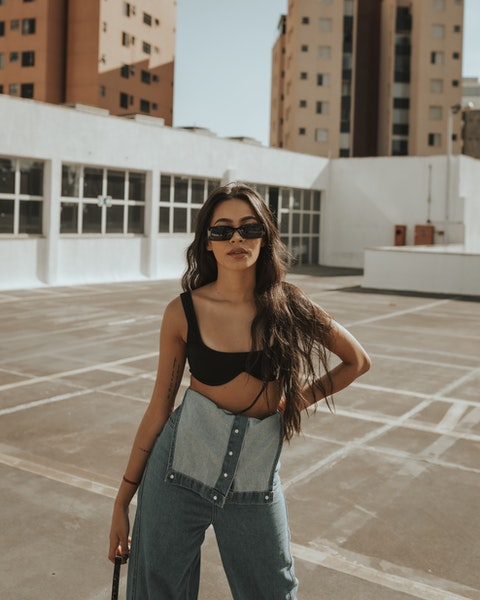

### Result

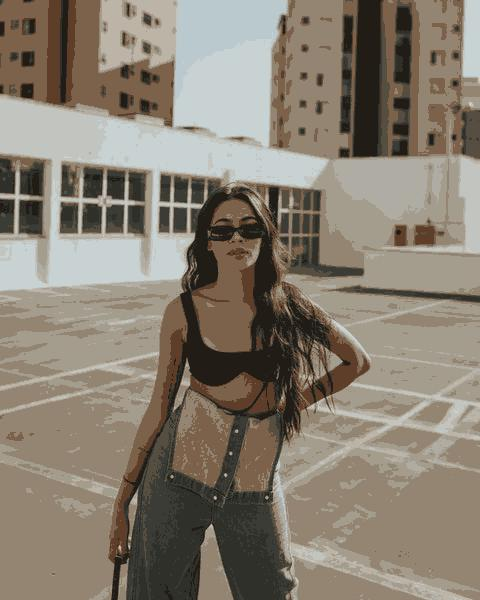


## Conclusion and future work

Given that we are operating on a pixel level, there are a lot of noise generated in the final product. One solution to remove or offset such noise would be the use of a blurring algorithm such as Gaussian blur. 

[Full Github repo](https://github.com/lincolnh0/paint-by-numbers)